<a href="https://colab.research.google.com/github/Nicole0906/DLI_Group_Assignment/blob/main/Final_Thiesshalan_RandomForest_ModelTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Setup

In [ ]:
# ==============================
# 1) Setup
# ==============================
!pip install -q tabulate  # only needed package not in Colab by default

import os, random, time, subprocess, sys, pathlib
import numpy as np
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, f1_score,
    precision_recall_fscore_support, roc_curve
)
import joblib

# Reproducibility
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# (Colab) Mount Drive for backup (not for datasets)
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

print("✅ Setup complete. Working dir:", os.getcwd())
print("💾 Google Drive mounted at /content/gdrive (for backup only)")



Mounted at /content/gdrive
✅ Setup complete. Working dir: /content
💾 Google Drive mounted at /content/gdrive (for backup only)


2) Data Loading

In [ ]:
# ==============================
# 2) Data Loading (via GitHub raw CSV)
# ==============================
import os
import pandas as pd

# Direct raw CSV link from GitHub
DATA_URL = "https://raw.githubusercontent.com/Nicole0906/DLI_Group_Assignment/main/Phishing_Legitimate_full%203.csv"
LOCAL_FILE = "phishing_dataset.csv"

def load_dataset():
    if not os.path.exists(LOCAL_FILE):
        print("⬇️  Downloading dataset from GitHub …")
        os.system(f"wget -q -O {LOCAL_FILE} {DATA_URL}")
    else:
        print("📂 Using cached local dataset:", LOCAL_FILE)
    print("📦 Loading dataset into DataFrame …")
    return pd.read_csv(LOCAL_FILE), "GitHub"

df, DATA_SRC = load_dataset()
print(f"✅ Dataset loaded from {DATA_SRC}. Shape: {df.shape}")
display(df.head(3))



📂 Using cached local dataset: phishing_dataset.csv
📦 Loading dataset into DataFrame …
✅ Dataset loaded from GitHub. Shape: (10000, 50)


,id,NumDots,SubdomainLevel,PathLevel,UrlLength,NumDash,NumDashInHostname,AtSymbol,TildeSymbol,NumUnderscore,...,IframeOrFrame,MissingTitle,ImagesOnlyInForm,SubdomainLevelRT,UrlLengthRT,PctExtResourceUrlsRT,AbnormalExtFormActionR,ExtMetaScriptLinkRT,PctExtNullSelfRedirectHyperlinksRT,CLASS_LABEL
0,1,3,1,5,72,0,0,0,0,0,...,0,0,1,1,0,1,1,-1,1,1
1,2,3,1,3,144,0,0,0,0,2,...,0,0,0,1,-1,1,1,1,1,1
2,3,3,1,2,58,0,0,0,0,0,...,0,0,0,1,0,-1,1,-1,0,1


3) Pre-Processing

In [ ]:
# ==============================
# 3) Pre-processing
# ==============================
# Lecturer requirements: show class counts and feature list, handle labels, balancing strategy if needed.

TARGET_COL = "CLASS_LABEL"

# 3.1 Ensure target exists
assert TARGET_COL in df.columns, f"{TARGET_COL} not in columns!"

# 3.2 Convert labels {-1,1} -> {0,1} if found
if set(df[TARGET_COL].unique()) == {-1, 1} or -1 in set(df[TARGET_COL].unique()):
    print("🔄 Converting labels -1→0, 1→1")
    df[TARGET_COL] = df[TARGET_COL].replace({-1: 0, 1: 1})

# 3.3 Drop ID-like columns if present
ID_COLS = [c for c in ["id", "ID", "Id"] if c in df.columns]
X = df.drop(columns=ID_COLS + [TARGET_COL])
y = df[TARGET_COL]

# 3.4 Feature & class summary
feature_list = X.columns.tolist()
class_counts = y.value_counts().sort_index()
class_table = [[lbl, int(class_counts.get(lbl, 0))] for lbl in sorted(class_counts.index)]
print("\n📊 Samples per class:")
print(tabulate(class_table, headers=["Class", "Count"], tablefmt="grid"))
print("\n🧰 Number of features:", len(feature_list))
print("📝 Feature list (first 20 shown):\n", feature_list[:20], ("..." if len(feature_list)>20 else ""))

# 3.5 Simple imbalance check (positives should be reasonably represented)
pos_rate = y.mean()
print(f"\n⚖️  Positive class rate: {pos_rate:.3f}")
IMBALANCED = (pos_rate < 0.35) or (pos_rate > 0.65)

# We’ll use class_weight='balanced' if imbalanced; otherwise, uniform weights.
CLASS_WEIGHT = "balanced" if IMBALANCED else None
print(f"Class weighting: {CLASS_WEIGHT if CLASS_WEIGHT else 'None (dataset seems roughly balanced)'}")

# 3.6 Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)
print("\nSplit shapes:", X_train.shape, X_test.shape)

# NOTE (optional): If you prefer resampling instead of class_weight, you can use SMOTE/RandomUnderSampler.
# That adds an extra dependency (imbalanced-learn) and time. For now we keep it light & fast.



📊 Samples per class:
+---------+---------+
|   Class |   Count |
+=========+=========+
|       0 |    5000 |
+---------+---------+
|       1 |    5000 |
+---------+---------+

🧰 Number of features: 48
📝 Feature list (first 20 shown):
 ['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore', 'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash', 'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPaths', 'HttpsInHostname'] ...

⚖️  Positive class rate: 0.500
Class weighting: None (dataset seems roughly balanced)

Split shapes: (8000, 48) (2000, 48)


4) Model (Random Forest)

In [ ]:
# ==============================
# 4) Model (Random Forest)
# ==============================
# Fast + strong baseline for tabular phishing data. Tuned for <5 minutes runtime on Colab CPU.

rf = RandomForestClassifier(
    n_estimators=1000,        # good balance of accuracy/speed
    max_depth=20,         # let trees grow; can set e.g. 20 if overfitting
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",    # typical RF default
    bootstrap=True,
    class_weight=CLASS_WEIGHT,  # auto if imbalanced
    random_state=SEED,
    n_jobs=-1               # use all CPU cores for speed
)

print(rf)


RandomForestClassifier(max_depth=20, n_estimators=1000, n_jobs=-1,
                       random_state=42)


5) Training

In [ ]:
# ==============================
# 5) Training
# ==============================
start_train = time.time()
rf.fit(X_train, y_train)
train_time = time.time() - start_train
print(f"⏱️  Training done in {train_time:.2f}s")

# Optional: quick model size stats (approximate)
num_nodes = sum(estimator.tree_.node_count for estimator in rf.estimators_)
print(f"🌲 Trees: {len(rf.estimators_)}, total nodes across forest: {num_nodes}")


⏱️  Training done in 15.89s
🌲 Trees: 1000, total nodes across forest: 767720


6) Evaluation

⚡ Inference latency: 0.245 ms/sample
🎯 Best F1 = 0.987 at threshold = 0.50

📑 Final Results
+--------------+------------+-------------+----------+-------+-----------+---------+------------+-------------+-----------+----------------+-------------+----------------+
| Model        |   Accuracy |   Precision |   Recall |    F1 |   ROC-AUC |   Nodes |   Inf (ms) |   Train (s) |   Best Th |   n_estimators |   max_depth | class_weight   |
+==============+============+=============+==========+=======+===========+=========+============+=============+===========+================+=============+================+
| RandomForest |      0.988 |       0.988 |    0.988 | 0.987 |     0.999 |  767720 |      0.245 |       15.89 |       0.5 |           1000 |          20 | None           |
+--------------+------------+-------------+----------+-------+-----------+---------+------------+-------------+-----------+----------------+-------------+----------------+


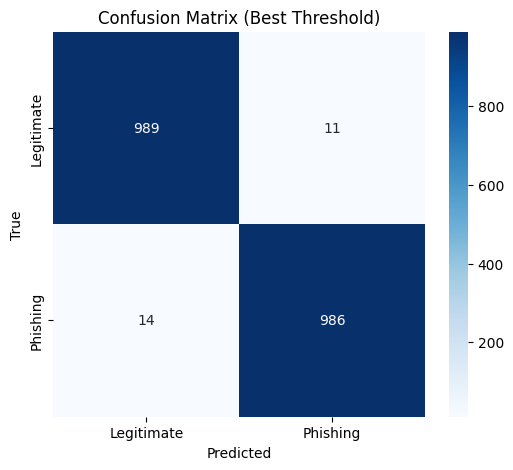

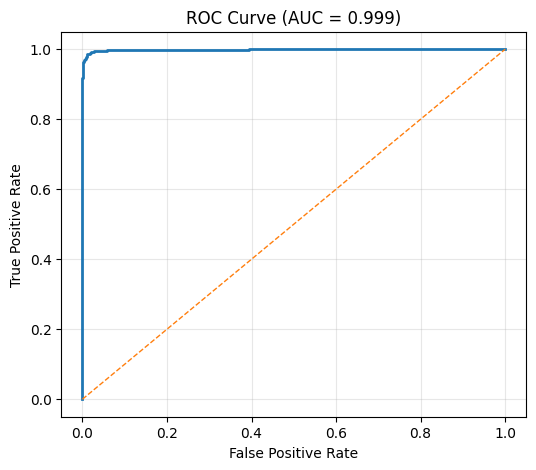

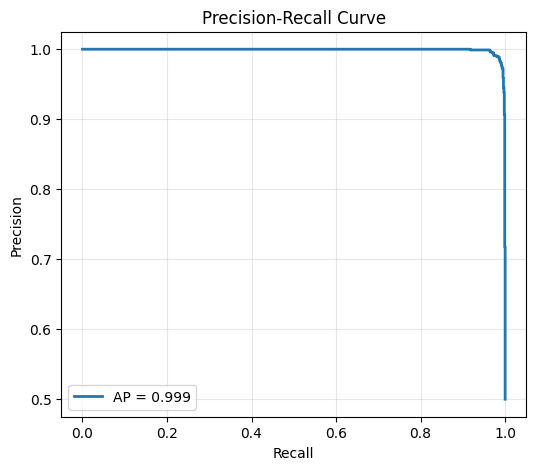

In [ ]:
# ==============================
# 6) Evaluation
# ==============================
label_map = {0: "Legitimate", 1: "Phishing"}

# 6.1 Probabilities & inference latency
start_inf = time.time()
y_prob = rf.predict_proba(X_test)[:, 1]
inf_time_ms = (time.time() - start_inf) / len(X_test) * 1000.0
print(f"⚡ Inference latency: {inf_time_ms:.3f} ms/sample")

# 6.2 Threshold tuning for best F1
best_th, best_f1 = 0.50, 0.0
for th in np.arange(0.30, 0.71, 0.01):
    y_tmp = (y_prob >= th).astype(int)
    f1 = f1_score(y_test, y_tmp)
    if f1 > best_f1:
        best_f1, best_th = f1, th

y_pred = (y_prob >= best_th).astype(int)
print(f"🎯 Best F1 = {best_f1:.3f} at threshold = {best_th:.2f}")

# 6.3 Metrics
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob)

# 6.4 Get params
rf_params = rf.get_params()
cw = rf_params["class_weight"] if rf_params["class_weight"] is not None else "None"

# 6.5 Tabulated summary (with params)
results_table = [[
    "RandomForest",
    round(report["accuracy"], 3),
    round(report["weighted avg"]["precision"], 3),
    round(report["weighted avg"]["recall"], 3),
    round(report["weighted avg"]["f1-score"], 3),
    round(roc_auc, 3),
    num_nodes,
    round(inf_time_ms, 3),
    round(train_time, 2),
    best_th,
    rf_params["n_estimators"],
    rf_params["max_depth"],
    cw
]]

print("\n📑 Final Results")
print(tabulate(
    results_table,
    headers=[
        "Model","Accuracy","Precision","Recall","F1","ROC-AUC",
        "Nodes","Inf (ms)","Train (s)","Best Th",
        "n_estimators","max_depth","class_weight"
    ],
    tablefmt="grid"
))

# 6.6 Confusion Matrix (visual 1)
cm = confusion_matrix(y_test, y_pred, labels=[0,1])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_map[0], label_map[1]],
            yticklabels=[label_map[0], label_map[1]])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Best Threshold)")
plt.show()

# 6.7 ROC Curve (visual 2)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.3f})")
plt.grid(True, alpha=0.3)
plt.show()

# 6.8 Precision-Recall Curve (visual 3)
from sklearn.metrics import precision_recall_curve, average_precision_score
prec, rec, _ = precision_recall_curve(y_test, y_prob)
avg_prec = average_precision_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, linewidth=2, label=f"AP = {avg_prec:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



7) Save Model

In [ ]:
# ==============================
# 7) Save Model (Drive + Local Download)
# ==============================
from google.colab import files

# Save to Google Drive (persistent backup)
MODEL_PATH = "/content/gdrive/MyDrive/Colab Notebooks/DLI_ASSIGNMENT/Thiesshalan_RandomForest_model.pkl"
joblib.dump(rf, MODEL_PATH)
size_mb = os.path.getsize(MODEL_PATH) / (1024*1024)
print(f"💾 Model saved to Google Drive at: {MODEL_PATH}  (size: {size_mb:.2f} MB)")

# Also save a copy in Colab's local runtime
LOCAL_PATH = "Thiesshalan_RandomForest_model.pkl"
joblib.dump(rf, LOCAL_PATH)

# Auto-download to your PC
files.download(LOCAL_PATH)

# One-line verdict
TARGET_F1 = 0.98
final_f1 = round(report["weighted avg"]["f1-score"], 3)
verdict = "target met ✅" if final_f1 >= TARGET_F1 else "target not met ❌"
print(f"\nAchieved F1 = {final_f1}, target = {TARGET_F1} → {verdict}")


💾 Model saved to Google Drive at: /content/gdrive/MyDrive/Colab Notebooks/DLI_ASSIGNMENT/Thiesshalan_RandomForest_model.pkl  (size: 58.96 MB)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Achieved F1 = 0.987, target = 0.98 → target met ✅
